In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d dhruvildave/spotify-charts

Dataset URL: https://www.kaggle.com/datasets/dhruvildave/spotify-charts
License(s): ODbL-1.0
 99% 932M/945M [00:10<00:00, 166MB/s]
100% 945M/945M [00:10<00:00, 92.8MB/s]


In [ ]:
from zipfile import ZipFile
dataset = '/content/spotify-charts.zip'
with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('charts.csv')
df.head(10)

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0
5,Traicionera,6,2017-01-01,Sebastian Yatra,https://open.spotify.com/track/5J1c3M4EldCfNxX...,Argentina,top200,MOVE_DOWN,151140.0
6,Cuando Se Pone a Bailar,7,2017-01-01,Rombai,https://open.spotify.com/track/1MpKZi1zTXpERKw...,Argentina,top200,MOVE_DOWN,148369.0
7,Otra vez (feat. J Balvin),8,2017-01-01,Zion & Lennox,https://open.spotify.com/track/3QwBODjSEzelZyV...,Argentina,top200,MOVE_DOWN,143004.0
8,La Bicicleta,9,2017-01-01,"Carlos Vives, Shakira",https://open.spotify.com/track/0sXvAOmXgjR2QUq...,Argentina,top200,MOVE_UP,126389.0
9,Dile Que Tu Me Quieres,10,2017-01-01,Ozuna,https://open.spotify.com/track/20ZAJdsKB5IGbGj...,Argentina,top200,MOVE_DOWN,112012.0


In [4]:
#checking the count to repeated region then picking the highest one
df['region'].value_counts()

,count
region,
Argentina,455308
United States,455057
Austria,454593
Brazil,454439
Australia,453103
...,...
Ukraine,127544
Russia,126837
Luxembourg,98053


In [5]:
#Picking and storing the city that i will use in (df_Arg)
df_Arg = df.loc[df['region']=='Argentina']
print(f"The data will be used {df_Arg.shape}")

The data will be used (455308, 9)


In [6]:
#converting the column (date) to type datetime
df_Arg['date']= pd.to_datetime(df_Arg['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26173514 entries, 0 to 26173513
Data columns (total 9 columns):
 #   Column   Dtype  
---  ------   -----  
 0   title    object 
 1   rank     int64  
 2   date     object 
 3   artist   object 
 4   url      object 
 5   region   object 
 6   chart    object 
 7   trend    object 
 8   streams  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 1.8+ GB


In [7]:
#checking the missing values
df_Arg.isna().sum()

,0
title,0
rank,0
date,0
artist,0
url,0
region,0
chart,0
trend,0
streams,90923


In [8]:
#dropping the missing values of streams
df_Arg.dropna(subset = ['streams'],inplace=True)
df_Arg.isna().sum()

,0
title,0
rank,0
date,0
artist,0
url,0
region,0
chart,0
trend,0
streams,0


In [9]:
#understanding the statistical analysis of the numerical cols
describe_round = df_Arg.describe()
describe_round.round(2)

,rank,date,streams
count,364385.00,364385,364385.00
mean,100.50,2019-07-03 07:00:23.721064448,53607.62
min,1.00,2017-01-01 00:00:00,9747.00
25%,51.00,2018-04-04 00:00:00,24144.00
50%,101.00,2019-07-04 00:00:00,34218.00
75%,151.00,2020-10-01 00:00:00,59274.00
max,200.00,2021-12-31 00:00:00,858467.00
std,57.73,NaN,54668.80


In [10]:
#seeing info about the data
df_Arg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364385 entries, 0 to 25180359
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   title    364385 non-null  object        
 1   rank     364385 non-null  int64         
 2   date     364385 non-null  datetime64[ns]
 3   artist   364385 non-null  object        
 4   url      364385 non-null  object        
 5   region   364385 non-null  object        
 6   chart    364385 non-null  object        
 7   trend    364385 non-null  object        
 8   streams  364385 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 27.8+ MB


In [11]:
#dropping the cols that i dont need
df_Arg.drop(['url','chart'],axis=1,inplace=True)
df_Arg.columns

Index(['title', 'rank', 'date', 'artist', 'region', 'trend', 'streams'], dtype='object')

In [12]:
#added a column that calculates the total streams of an artist
artist_popularity = df_Arg.groupby('artist')['streams'].sum().reset_index()
artist_popularity.columns = ['artist', 'artist_total_streams']
df_Arg = df_Arg.merge(artist_popularity)
df_Arg

,title,rank,date,artist,region,trend,streams,artist_total_streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,Argentina,SAME_POSITION,253019.0,69972158.0
1,Chantaje (feat. Maluma),1,2017-01-02,Shakira,Argentina,SAME_POSITION,185399.0,69972158.0
2,Perro Fiel (feat. Nicky Jam),45,2018-03-01,Shakira,Argentina,SAME_POSITION,66433.0,69972158.0
3,Trap (feat. Maluma),116,2018-03-01,Shakira,Argentina,MOVE_DOWN,21981.0,69972158.0
4,Chantaje (feat. Maluma),157,2018-03-01,Shakira,Argentina,MOVE_UP,17874.0,69972158.0
...,...,...,...,...,...,...,...,...
364380,Se Le Ve,141,2021-08-30,"Sech, Dalex, Rich Music LTD, Justin Quiles, Ar...",Argentina,MOVE_UP,36788.0,438525.0
364381,Se Le Ve,122,2021-08-31,"Sech, Dalex, Rich Music LTD, Justin Quiles, Ar...",Argentina,MOVE_UP,41289.0,438525.0
364382,Zombie,137,2018-01-16,The Cranberries,Argentina,NEW_ENTRY,20833.0,37831.0
364383,Linger,184,2018-01-16,The Cranberries,Argentina,NEW_ENTRY,16998.0,37831.0


In [13]:
#Adding column year
df_Arg['year'] = df_Arg['date'].dt.year
df_Arg

,title,rank,date,artist,region,trend,streams,artist_total_streams,year
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,Argentina,SAME_POSITION,253019.0,69972158.0,2017
1,Chantaje (feat. Maluma),1,2017-01-02,Shakira,Argentina,SAME_POSITION,185399.0,69972158.0,2017
2,Perro Fiel (feat. Nicky Jam),45,2018-03-01,Shakira,Argentina,SAME_POSITION,66433.0,69972158.0,2018
3,Trap (feat. Maluma),116,2018-03-01,Shakira,Argentina,MOVE_DOWN,21981.0,69972158.0,2018
4,Chantaje (feat. Maluma),157,2018-03-01,Shakira,Argentina,MOVE_UP,17874.0,69972158.0,2018
...,...,...,...,...,...,...,...,...,...
364380,Se Le Ve,141,2021-08-30,"Sech, Dalex, Rich Music LTD, Justin Quiles, Ar...",Argentina,MOVE_UP,36788.0,438525.0,2021
364381,Se Le Ve,122,2021-08-31,"Sech, Dalex, Rich Music LTD, Justin Quiles, Ar...",Argentina,MOVE_UP,41289.0,438525.0,2021
364382,Zombie,137,2018-01-16,The Cranberries,Argentina,NEW_ENTRY,20833.0,37831.0,2018
364383,Linger,184,2018-01-16,The Cranberries,Argentina,NEW_ENTRY,16998.0,37831.0,2018


In [14]:
#adding col average streams
average_streams_per_song = df.groupby(['title', 'artist'])['streams'].mean().reset_index()
df_Arg = df_Arg.merge(average_streams_per_song, on=['title', 'artist'], how='left')
df_Arg.rename(columns={'streams_x':'streams','streams_y':'average_streams'},inplace=True)
df_Arg

,title,rank,date,artist,region,trend,streams,artist_total_streams,year,average_streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,Argentina,SAME_POSITION,253019.0,69972158.0,2017,56453.528158
1,Chantaje (feat. Maluma),1,2017-01-02,Shakira,Argentina,SAME_POSITION,185399.0,69972158.0,2017,56453.528158
2,Perro Fiel (feat. Nicky Jam),45,2018-03-01,Shakira,Argentina,SAME_POSITION,66433.0,69972158.0,2018,55636.434033
3,Trap (feat. Maluma),116,2018-03-01,Shakira,Argentina,MOVE_DOWN,21981.0,69972158.0,2018,15330.939686
4,Chantaje (feat. Maluma),157,2018-03-01,Shakira,Argentina,MOVE_UP,17874.0,69972158.0,2018,56453.528158
...,...,...,...,...,...,...,...,...,...,...
364380,Se Le Ve,141,2021-08-30,"Sech, Dalex, Rich Music LTD, Justin Quiles, Ar...",Argentina,MOVE_UP,36788.0,438525.0,2021,23568.034483
364381,Se Le Ve,122,2021-08-31,"Sech, Dalex, Rich Music LTD, Justin Quiles, Ar...",Argentina,MOVE_UP,41289.0,438525.0,2021,23568.034483
364382,Zombie,137,2018-01-16,The Cranberries,Argentina,NEW_ENTRY,20833.0,37831.0,2018,23611.259873
364383,Linger,184,2018-01-16,The Cranberries,Argentina,NEW_ENTRY,16998.0,37831.0,2018,35633.176136


In [15]:
print(df_Arg.duplicated().sum())
df_Arg.drop_duplicates(inplace=True)
print(df_Arg.duplicated().sum())

0
0


In [16]:
#sava data into csv so it can be used later for streamlit
df_Arg.to_csv('df_Arg.csv',index=False)

<Axes: >

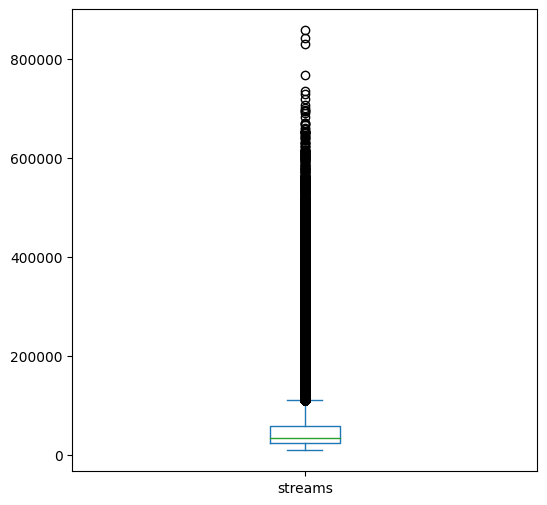

In [17]:
#checking the outliers and 25% / 75% quantile
df_Arg['streams'].plot(kind='box',figsize=(6,6))

In [18]:
#Number of Outliters
numerical_values = df_Arg.select_dtypes(include=['int64', 'float64'])
Q1 = numerical_values.quantile(0.25)
Q3 = numerical_values.quantile(0.75)
IQR = Q3 - Q1
outliers = ((numerical_values < (Q1 - 1.5 * IQR)) | (numerical_values > (Q3 + 1.5 * IQR))).any(axis=1)
outliers.sum()

75295

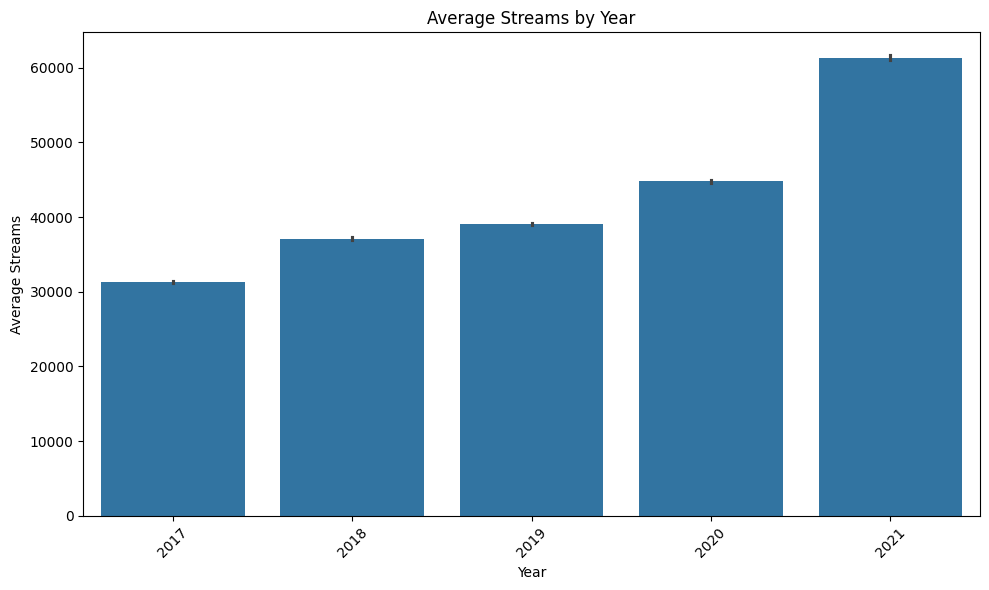

In [19]:
#Average Streams By Year using bar

plt.figure(figsize=(10, 6))
sns.barplot(data=df_Arg, x='year', y='average_streams')
plt.title('Average Streams by Year')
plt.xlabel('Year')
plt.ylabel('Average Streams')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


858467.0


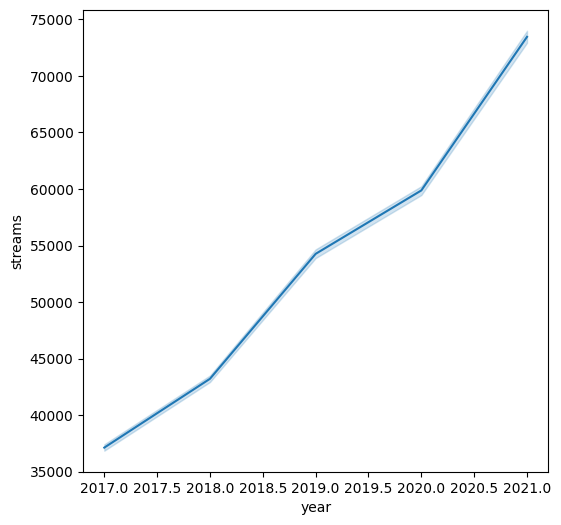

In [20]:
#Seeing rate of streams in each year (High-Low)
figsize = (6,6)
plt.figure(figsize=figsize)
sns.lineplot(x='year',y='streams',data=df_Arg)
print(df_Arg['streams'].max())

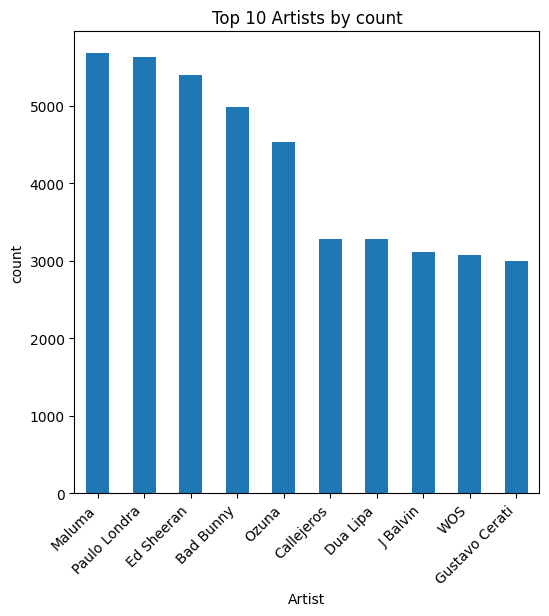

In [21]:
# top 10 artists
df_Arg['artist'].value_counts().head(10).plot(kind='bar', figsize=(6, 6))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Artist')
plt.ylabel('count')
plt.title('Top 10 Artists by count')
plt.show()

                title     streams
2            Me Gusta  68487692.0
3         Nunca quise  54250969.0
4  Spaghetti del Rock  50344453.0
1              Crimen  49737936.0
0                Creo  45356309.0


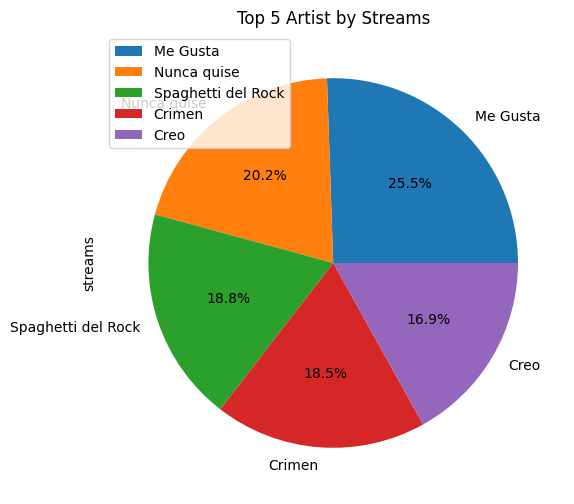

In [22]:
# Identifying top 5 songs and filtering the data for only 5 top songs
top_5_songs = df_Arg['title'].value_counts().head(5).index
top_5_data = df_Arg[df_Arg['title'].isin(top_5_songs)]
top_5_streams = top_5_data.groupby('title')['streams'].sum().reset_index()

top_5_streams_sorted = top_5_streams.sort_values(by='streams', ascending=False)
print(top_5_streams_sorted)

top_5_streams_sorted.set_index('title').plot(kind='pie', y='streams', figsize=(10, 6), autopct='%1.1f%%')
plt.title('Top 5 Artist by Streams')
plt.show()


         artist      streams
4  Paulo Londra  362672002.0
2        Maluma  360531136.0
0     Bad Bunny  326496011.0
3         Ozuna  287950180.0
1    Ed Sheeran  182811165.0


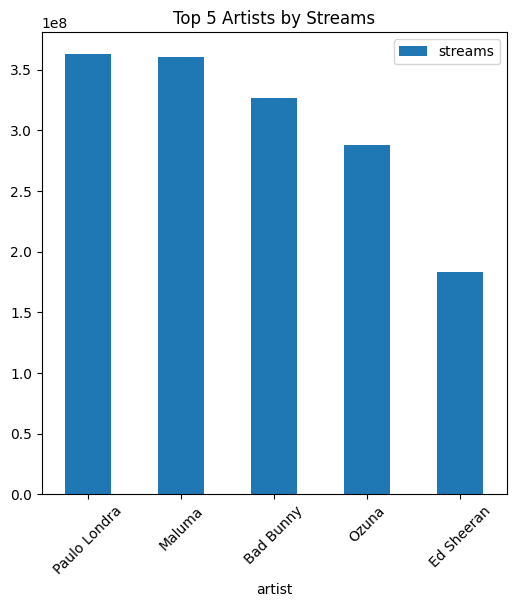

In [23]:
# Identifying top 5 Artist and filtering the data for only 5 top songs
top_5_artists = df_Arg['artist'].value_counts().head(5).index
top_5_data = df_Arg[df_Arg['artist'].isin(top_5_artists)]
top_5_streams = top_5_data.groupby('artist')['streams'].sum().reset_index()
top_5_streams

top_5_streams_sorted = top_5_streams.sort_values(by='streams', ascending=False)
print(top_5_streams_sorted)

top_5_streams_sorted.set_index('artist').plot(kind='bar', y='streams', figsize=(6, 6))
plt.title('Top 5 Artists by Streams')
plt.xticks(rotation=45)
plt.show()


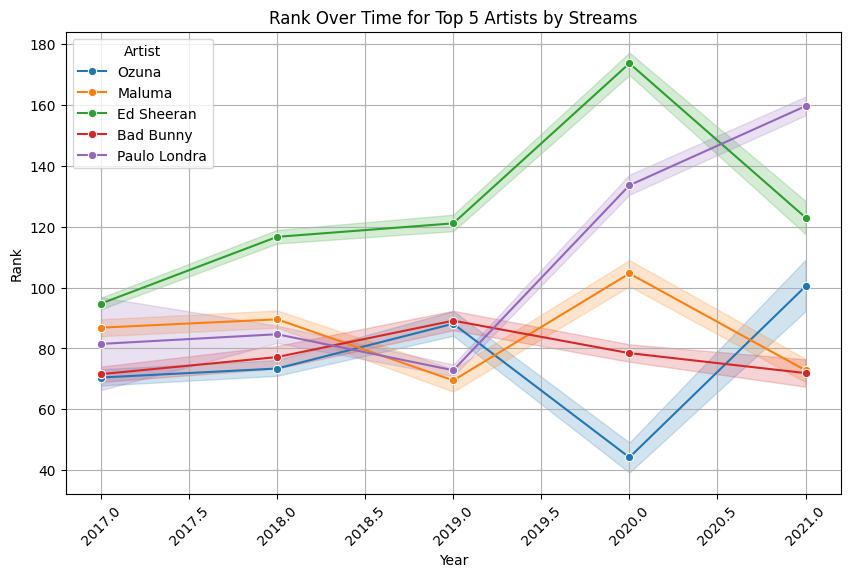

In [24]:
#Visualizing based on the top 5 artists and its rank per year
top_5_artists = df_Arg['artist'].value_counts().head(5).index
top_5_data = df_Arg[df_Arg['artist'].isin(top_5_artists)]
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='rank', hue='artist', data=top_5_data, marker='o')

plt.title('Rank Over Time for Top 5 Artists by Streams')
plt.xlabel('Year')
plt.ylabel('Rank')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Artist')
plt.show()



title
Me Gusta              2141
Crimen                1811
Spaghetti del Rock    1806
Nunca quise           1789
Creo                  1726
Name: count, dtype: int64


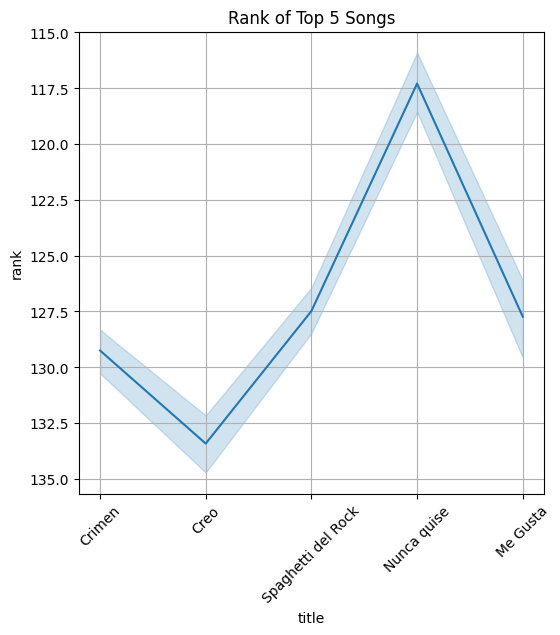

In [25]:
#rank of top 5 songs
top_5_songs = df_Arg['title'].value_counts().head(5)
df5_songs = df_Arg[df_Arg['title'].isin(top_5_songs.index)]
print(top_5_songs)
plt.figure(figsize=(6, 6))
sns.lineplot(x='title',y='rank',data=df5_songs)
plt.grid(True)
plt.title('Rank of Top 5 Songs')
plt.xticks(rotation=45)
plt.gca().invert_yaxis()

In [16]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [17]:
!npm install localtunnel


added 22 packages, and audited 23 packages in 5s

3 packages are looking for funding
  run `npm fund` for details

2 moderate severity vulnerabilities

To address all issues, run:
  npm audit fix

Run `npm audit` for details.


In [26]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 35.231.248.237


In [ ]:
# run streamlit server in backgound
!streamlit run  app.py&>/content/logs.txt & npx localtunnel --port 8501

your url is: https://chubby-eels-say.loca.lt


# ***Using ML Model***

In [28]:
#encoding the data using LabelEncoder
le = LabelEncoder()
df_Arg['title'] = le.fit_transform(df_Arg['title'])
df_Arg['date']= le.fit_transform(df_Arg['date'])
df_Arg['artist'] = le.fit_transform(df_Arg['artist'])
df_Arg['trend'] = le.fit_transform(df_Arg['trend'])
df_Arg

,title,rank,date,artist,region,trend,streams,artist_total_streams,year,average_streams
0,522,1,0,1546,Argentina,3,253019.0,69972158.0,2017,56453.528158
1,522,1,1,1546,Argentina,3,185399.0,69972158.0,2017,56453.528158
2,2190,45,421,1546,Argentina,3,66433.0,69972158.0,2018,55636.434033
3,2925,116,421,1546,Argentina,0,21981.0,69972158.0,2018,15330.939686
4,522,157,421,1546,Argentina,1,17874.0,69972158.0,2018,56453.528158
...,...,...,...,...,...,...,...,...,...,...
364380,2495,141,1699,1530,Argentina,1,36788.0,438525.0,2021,23568.034483
364381,2495,122,1700,1530,Argentina,1,41289.0,438525.0,2021,23568.034483
364382,3217,137,377,1608,Argentina,2,20833.0,37831.0,2018,23611.259873
364383,1581,184,377,1608,Argentina,2,16998.0,37831.0,2018,35633.176136


In [37]:
#Picking The features and the target
#ML Model: Decision Tree
X = df_Arg[['title', 'date', 'trend', 'streams', 'average_streams']]
y = df_Arg['artist']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
#Accuracy Of the Model
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2*100}")

Mean Squared Error: 1713.0206237907707
R-squared: 99.31025135894916


In [38]:
#Accuracy of the training data
#checking from here if its overfitting/underfitting
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Training MSE: {train_mse}")
print(f"Training R-squared: {train_r2*100}")


Training MSE: 0.0
Training R-squared: 100.0
